# Using pretrained models (PyTorch)

Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]

Model Hub можно найти в любой нисходящей библиотеке. Рассмотрим, как использовать одну из этих моделей.
Допустим, мы ищем французскую модель, которая может выполнять заполнение маски.

In [4]:
# Использования токена:
import os
from huggingface_hub import login
login(os.getenv("HF_TOKEN"))

In [8]:
from transformers import pipeline

camembert_fill_mask = pipeline("fill-mask", model="camembert-base")
results = camembert_fill_mask("Le ciel est <mask> aujourd'hui.)")

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing CamembertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


In [9]:
results

[{'score': 0.19554701447486877,
  'token': 1509,
  'token_str': 'magnifique',
  'sequence': "Le ciel est magnifique aujourd'hui.)"},
 {'score': 0.15100200474262238,
  'token': 22334,
  'token_str': 'nuageux',
  'sequence': "Le ciel est nuageux aujourd'hui.)"},
 {'score': 0.1184326633810997,
  'token': 15941,
  'token_str': 'dégagé',
  'sequence': "Le ciel est dégagé aujourd'hui.)"},
 {'score': 0.05510546267032623,
  'token': 5830,
  'token_str': 'couvert',
  'sequence': "Le ciel est couvert aujourd'hui.)"},
 {'score': 0.04563208669424057,
  'token': 1549,
  'token_str': 'bleu',
  'sequence': "Le ciel est bleu aujourd'hui.)"}]

Нужно следить, чтобы выбранная контрольная точка подходила для задачи, для которой она будет использоваться. Здесь мы загружаем контрольную точку __camembert-base__ в конвейер _fill-mask_, что совершенно нормально (эта модель для этого и предназначена). Но если бы мы загрузили эту контрольную точку в конвейер __text-classification__, результаты не имели бы никакого смысла, поскольку заголовок camembert-base не подходит для этой задачи! Мы рекомендуем использовать селектор задач в интерфейсе Hugging Face Hub для выбора соответствующих контрольных точек:

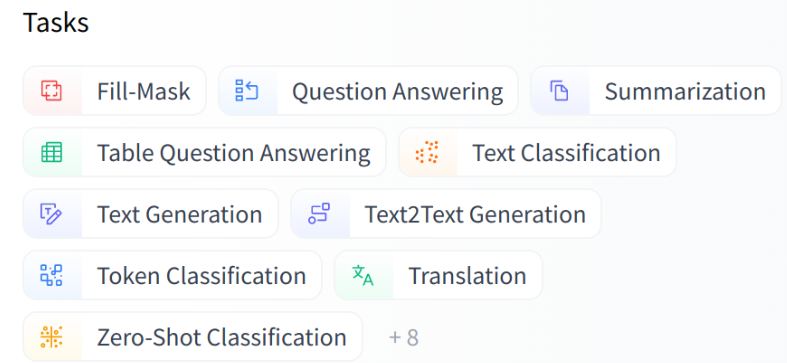

Вы также можете создать экземпляр контрольной точки, используя архитектуру модели напрямую:

In [ ]:
from transformers import CamembertTokenizer, CamembertForMaskedLM

tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
model = CamembertForMaskedLM.from_pretrained("camembert-base")

Однако мы рекомендуем использовать вместо этого классы Auto*, поскольку они по своей сути не зависят от архитектуры. В то время как предыдущий пример кода ограничивает пользователей контрольными точками, загружаемыми в архитектуре CamemBERT, использование классов Auto* упрощает переключение контрольных точек:

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("camembert-base")
model = AutoModelForMaskedLM.from_pretrained("camembert-base")

Но эти примры не являются полным кодом для работы, ниже полный:

In [7]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
import torch

model_name = "camembert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name)

sentence = "Le ciel est <mask> aujourd'hui."
inputs = tokenizer(sentence, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
mask_token_index = (inputs.input_ids == tokenizer.mask_token_id).nonzero(as_tuple=True)[1]
predicted_token_id = logits[0, mask_token_index].argmax(dim=-1)

print(tokenizer.decode(predicted_token_id))

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing CamembertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


magnifique


## Расшифровка кода
```
with torch.no_grad():
    outputs = model(**inputs)
```
🔹 torch.no_grad() отключает вычисление градиентов, что:  
✅ Экономит память и ускоряет вычисления (полезно при инференсе).  
✅ Позволяет не хранить вычислительный граф, который нужен только для обучения.  
➡ Модель получает входные данные (inputs) и возвращает outputs без градиентов.

### logits = outputs.logits  
🔹 outputs.logits — это сырые предсказания модели (тензор формы [batch_size, sequence_length, vocab_size]).
- batch_size: количество предложений в батче.  
- sequence_length: количество токенов в предложении.  
- vocab_size: количество слов в словаре модели.  
➡ Каждый логит — это вероятность (до softmax) для каждого токена на каждом месте в предложении.



### Находим индекс токена <mask> в предложении
```
mask_token_index = (inputs.input_ids == tokenizer.mask_token_id).nonzero(as_tuple=True)[1]
```
🔹 __inputs.input_ids == tokenizer.mask_token_id__ - создает булевый тензор, где True, если токен — это `<mask>`.  
🔹 __.nonzero(as_tuple=True)[1]__ находит индексы True значений (позиции `<mask>` в предложении).

➡ Пример:
Если inputs.input_ids — это [101, 456, 103, 789, 102], где 103 — это `<mask>`,  
то mask_token_index будет tensor([2]) (позиция `<mask>`).

### Выбираем наиболее вероятное слово для `<mask>`  
```
predicted_token_id = logits[0, mask_token_index].argmax(dim=-1)  
```
- `logits[0, mask_token_index]` — достает логиты только для `<mask>`.
- `.argmax(dim=-1)` выбирает индекс (ID) токена с наибольшим логитом (самый вероятный вариант замены `<mask>`).

➡ Пример вывода:
Если predicted_token_id = tensor([456]), то модель предсказала, что `<mask>` нужно заменить на токен 456.

### Разбор выражения
####  `mask_token_index = (inputs.input_ids == tokenizer.mask_token_id).nonzero(as_tuple=True)[1]`

1. - `inputs.input_ids` — это числовое представление (токенизированная версия) предложения.  
Пример:
```
sentence = "Le ciel est <mask> aujourd'hui."
inputs = tokenizer(sentence, return_tensors="pt")
print(inputs.input_ids)
# Вывод (input_ids в формате PyTorch-тензора):  tensor([[101, 456, 103, 789, 102]])  
Где: 101 — [CLS] (специальный токен начала), 103 — `<mask>` (замаскированное слово), 102 — [SEP] (специальный токен конца).
```  

2. - `inputs.input_ids == tokenizer.mask_token_id` - Это сравнение создаёт булевый тензор:  
`tensor([[False, False,  True, False, False]])`  
True стоит там, где `<mask>`, то есть на 2-й позиции (индекс 2).  



3. - `(inputs.input_ids == tokenizer.mask_token_id).nonzero(as_tuple=True)`  
- `.nonzero()` - находит индексы, где значение True.
- `as_tuple=True` - делает вывод в виде кортежа из тензоров.  

➡ Пример вывода:
(torch.tensor([0]), torch.tensor([N]))
Где:

0 — индекс предложения в батче (если у нас batch_size = 1).
N — индекс `<mask>` в предложении.


Почему [1]?  
`mask_token_index = (inputs.input_ids == tokenizer.mask_token_id).nonzero(as_tuple=True)[1]`  
Мы выбираем только второй тензор ([1]), содержащий индексы `<mask>` в предложении. (в первом тензоре - индекс предложения в батче).

Если предложение содержит несколько `<mask>`, mask_token_index будет списком индексов.  
`tensor([1, 3])`